<a href="https://colab.research.google.com/github/wojciechsadlik/MGU-CGANMusicConverter/blob/main/raw_audio_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/MGU-CGANMusicConverter

/content/drive/MyDrive/Colab Notebooks/MGU-CGANMusicConverter


In [3]:
import os
import pickle
import numpy as np
from glob import glob
from keras.utils.np_utils import to_categorical
from librosa.util import normalize

In [4]:
def get_data(file_list):
  def load_into(filename, x, y):
    with open(filename, 'rb') as f:
      pkl_file = pickle.load(f)
      x.append(pkl_file['audio'])
      y.append(int(pkl_file['class_id']))

  x, y = [], []
  for filename in file_list:
    load_into(filename, x, y)

  return np.array(x), np.array(y)

In [5]:
from keras.layers.pooling import MaxPooling1D
from keras.backend import in_top_k
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras import regularizers, Input
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import Activation
from keras.layers import LeakyReLU, Add, Dense, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

AUDIO_LENGTH = 110250

def add_Res1D(y, kernel_size, filters, strides=1, downsample=False):
  y_shortcut = y

  y = Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same')(y)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)
  y = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(y)
  y = BatchNormalization()(y)

  if downsample or strides > 1:
    y_shortcut = Conv1D(filters=filters, kernel_size=1, strides=strides, padding='same')(y_shortcut)

  y = Add()([y_shortcut, y])
  y = LeakyReLU()(y)

  return y


def build_discriminator(input_shape=[AUDIO_LENGTH, 1]):

  X_input = Input(input_shape)
  
  y = Conv1D(128, kernel_size=5, strides=4, padding='same')(X_input)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)
  y = Conv1D(128, kernel_size=5, strides=4, padding='same')(y)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)
  y = Conv1D(64, kernel_size=5, strides=4, padding='same')(y)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)
  y = Flatten()(y)
  y = Dense(1, activation='sigmoid')(y)

  model = Model(inputs = X_input, outputs = y)

  model.summary()

  return model

In [6]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, beta_1=0.5), metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 110250, 1)]       0         
                                                                 
 conv1d (Conv1D)             (None, 27563, 128)        768       
                                                                 
 batch_normalization (BatchN  (None, 27563, 128)       512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 27563, 128)        0         
                                                                 
 conv1d_1 (Conv1D)           (None, 6891, 128)         82048     
                                                                 
 batch_normalization_1 (Batc  (None, 6891, 128)        512       
 hNormalization)                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
from keras.layers.convolutional import Conv1DTranspose
from keras.layers import Reshape, UpSampling1D


LATENT_DIM = 125
#LATENT_DIM = 245

def build_generator(input_shape=(LATENT_DIM, )):

  X_input = Input(input_shape)
  
  y = Dense(input_shape[0] * 128)(X_input)
  y = Reshape((input_shape[0], 128))(y)
  y = BatchNormalization()(y)
  y = UpSampling1D(49)(y)
  y = Conv1DTranspose(128, kernel_size=5, strides=3, padding='same')(y)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)
  y = Conv1DTranspose(128, kernel_size=5, strides=3, padding='same')(y)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)
  y = Conv1DTranspose(64, kernel_size=3, strides=2, padding='same')(y)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)
  y = Conv1D(1, kernel_size=3, padding='same', activation='tanh')(y)


  model = Model(inputs = X_input, outputs = y)

  model.summary()

  return model

In [8]:
generator = build_generator()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 125)]             0         
                                                                 
 dense_1 (Dense)             (None, 16000)             2016000   
                                                                 
 reshape (Reshape)           (None, 125, 128)          0         
                                                                 
 batch_normalization_3 (Batc  (None, 125, 128)         512       
 hNormalization)                                                 
                                                                 
 up_sampling1d (UpSampling1D  (None, 6125, 128)        0         
 )                                                               
                                                                 
 conv1d_transpose (Conv1DTra  (None, 18375, 128)       8204

In [9]:
z = Input(shape=(LATENT_DIM,))
sample = generator(z)
discriminator.trainable = False
valid = discriminator(sample)
combined_model = Model(z, valid)
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, beta_1=0.5))
combined_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 125)]             0         
                                                                 
 model_1 (Functional)        (None, 110250, 1)         2206721   
                                                                 
 model (Functional)          (None, 1)                 235393    
                                                                 
Total params: 2,442,114
Trainable params: 2,205,825
Non-trainable params: 236,289
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
batch_size = 32
half_batch = int(batch_size / 2)

real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

epochs = 4

DATASET_PATH = './audio_splitting/genres/jazz'
SAMPLES_LIST = os.listdir(DATASET_PATH)
SAMPLES_NUM = len(SAMPLES_LIST)
d_loss_history = []
d_acc_history = []
g_loss_history = []

In [11]:
batches_num = int(SAMPLES_NUM/half_batch)

for epoch in range(epochs):
  idx = np.arange(SAMPLES_NUM)
  np.random.shuffle(idx)

  d_loss_sum = 0
  d_acc_sum = 0
  g_loss_sum = 0

  for batch in range(batches_num):
    batch_idx = idx[batch*half_batch : (batch+1)*half_batch]
    
    real_samples, _ = get_data([
        os.path.join(DATASET_PATH, SAMPLES_LIST[i]) for i in batch_idx
      ])
    
    real_samples = normalize(real_samples, axis=1)
    
    #print("%d : batch %d samples loaded" % (epoch, batch))

    noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
    gen_samples = generator.predict(noise[0:half_batch])

    #print('fake samples generated')

    d_loss_real = discriminator.train_on_batch(real_samples, real_labels[0:half_batch])
    d_loss_fake = discriminator.train_on_batch(gen_samples, fake_labels[0:half_batch])
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    g_loss = combined_model.train_on_batch(noise, real_labels)

    d_loss_sum += d_loss[0]
    d_acc_sum += d_loss[1]
    g_loss_sum += g_loss

  d_loss_history.append(d_loss_sum/batches_num)
  g_loss_history.append(g_loss_sum/batches_num)
  d_acc_history.append(100*d_acc_sum/batches_num)
  
  print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]"
    % (epoch, d_loss_sum/batches_num, 100*d_acc_sum/batches_num, g_loss_sum/batches_num))

0 [D loss: 0.892924, acc.: 52.11%] [G loss: 0.724533]
1 [D loss: 0.398071, acc.: 84.12%] [G loss: 0.657709]
2 [D loss: 0.656098, acc.: 78.04%] [G loss: 2.231239]
3 [D loss: 0.008670, acc.: 100.00%] [G loss: 0.000609]


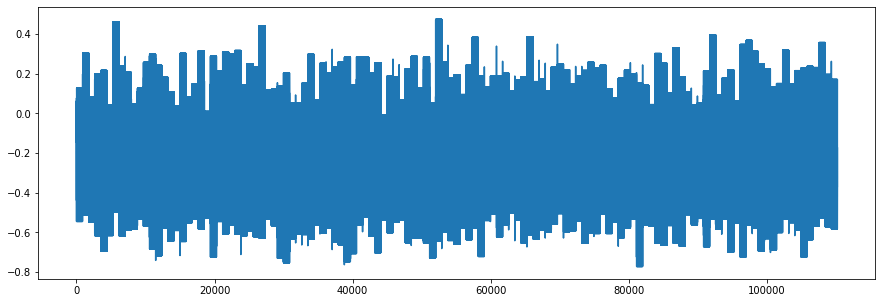

In [12]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (1, LATENT_DIM))
gen_sample = generator.predict(noise)
gen_sample = gen_sample.reshape(AUDIO_LENGTH, 1)

plt.figure(figsize=(15,5))
plt.plot(gen_sample)
plt.show()
#plt.savefig('gen_sample_dcgan' + str(len(g_loss_history)))

In [13]:
generator.save('generator_dcgan.h5')
discriminator.save('discriminator_dcgan.h5')

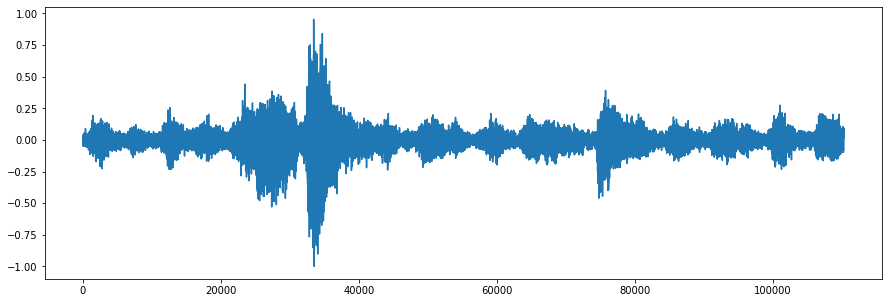

In [14]:
with open(DATASET_PATH + '/3000.pkl', 'rb') as f:
      pkl_file = pickle.load(f)
      plt.figure(figsize=(15,5))
      plt.plot(normalize(pkl_file['audio']))
      plt.show()


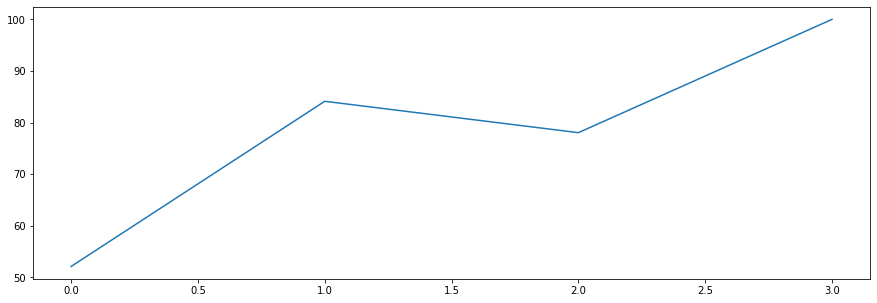

In [15]:
plt.figure(figsize=(15,5))
plt.plot(d_acc_history)

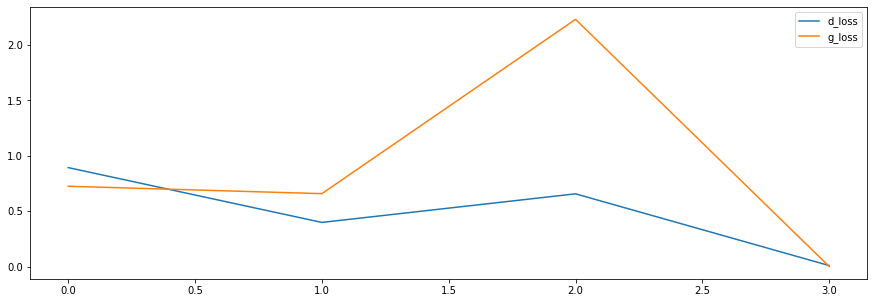

In [16]:
plt.figure(figsize=(15,5))
plt.plot(d_loss_history, label='d_loss')
plt.plot(g_loss_history, label='g_loss')
plt.legend()